# Using keras to apply filters to images

Example of using keras to apply traditional image filters to images. Instead of trying to learn the filters/kernels here we provide some filters by hand and simply use keras to apply them to the data.

This is useful to get a better feeling for what happens when you convolve an image with a kernel. We know what each kernel should do, there are only a few of them so we can look at each, etc

In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

# Silence warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

In [2]:
from keras.models import Model
# Conv2D is the operator to apply a convolution in 2D
# there are also 1D and 3D versions
from keras.layers import Conv2D, Input

from keras.datasets import mnist

Using TensorFlow backend.


In [3]:
# Load the MNIST digits dataset
(X_train, _), (_, _) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype(np.float64)

X_train /= 255

# add some noise
X_train_noisy = X_train + 0.05 * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)

In [4]:
# These are some very simple filters that detect
# basic things in an image.
horizontal_edge = [[0, 1., 0],
                   [0, -1., 0],
                   [0, 0, 0]]
vertical_edge = [[0, 0, 0],
                 [1, -1., 0],
                 [0, 0, 0]]
gaussian_filter = [[0.077847, 0.123317, 0.077847],
                   [0.123317, 0.195346, 0.123317],
                   [0.077847, 0.123317, 0.077847]]

In [5]:
# This is our simple NN that consists of a single
# Conv2D operator. We have three kernels that are
# each 3x3 pixels big.
x = Input((28, 28, 1))
h = Conv2D(3, (3,3))(x)
conv = Model(x, h)

In [6]:
def set_filter(kernel1, kernel2, kernel3):
    kernels, b = conv.get_weights()
    kernels[:,:,0,0] = kernel1
    kernels[:,:,0,1] = kernel2
    kernels[:,:,0,2] = kernel3
    conv.set_weights([kernels, b])

In [7]:
set_filter(horizontal_edge, vertical_edge, gaussian_filter)

In [8]:
# use the single filter and apply it to the first few training examples
n_examples = 4
X_conv = conv.predict(X_train_noisy[:n_examples])

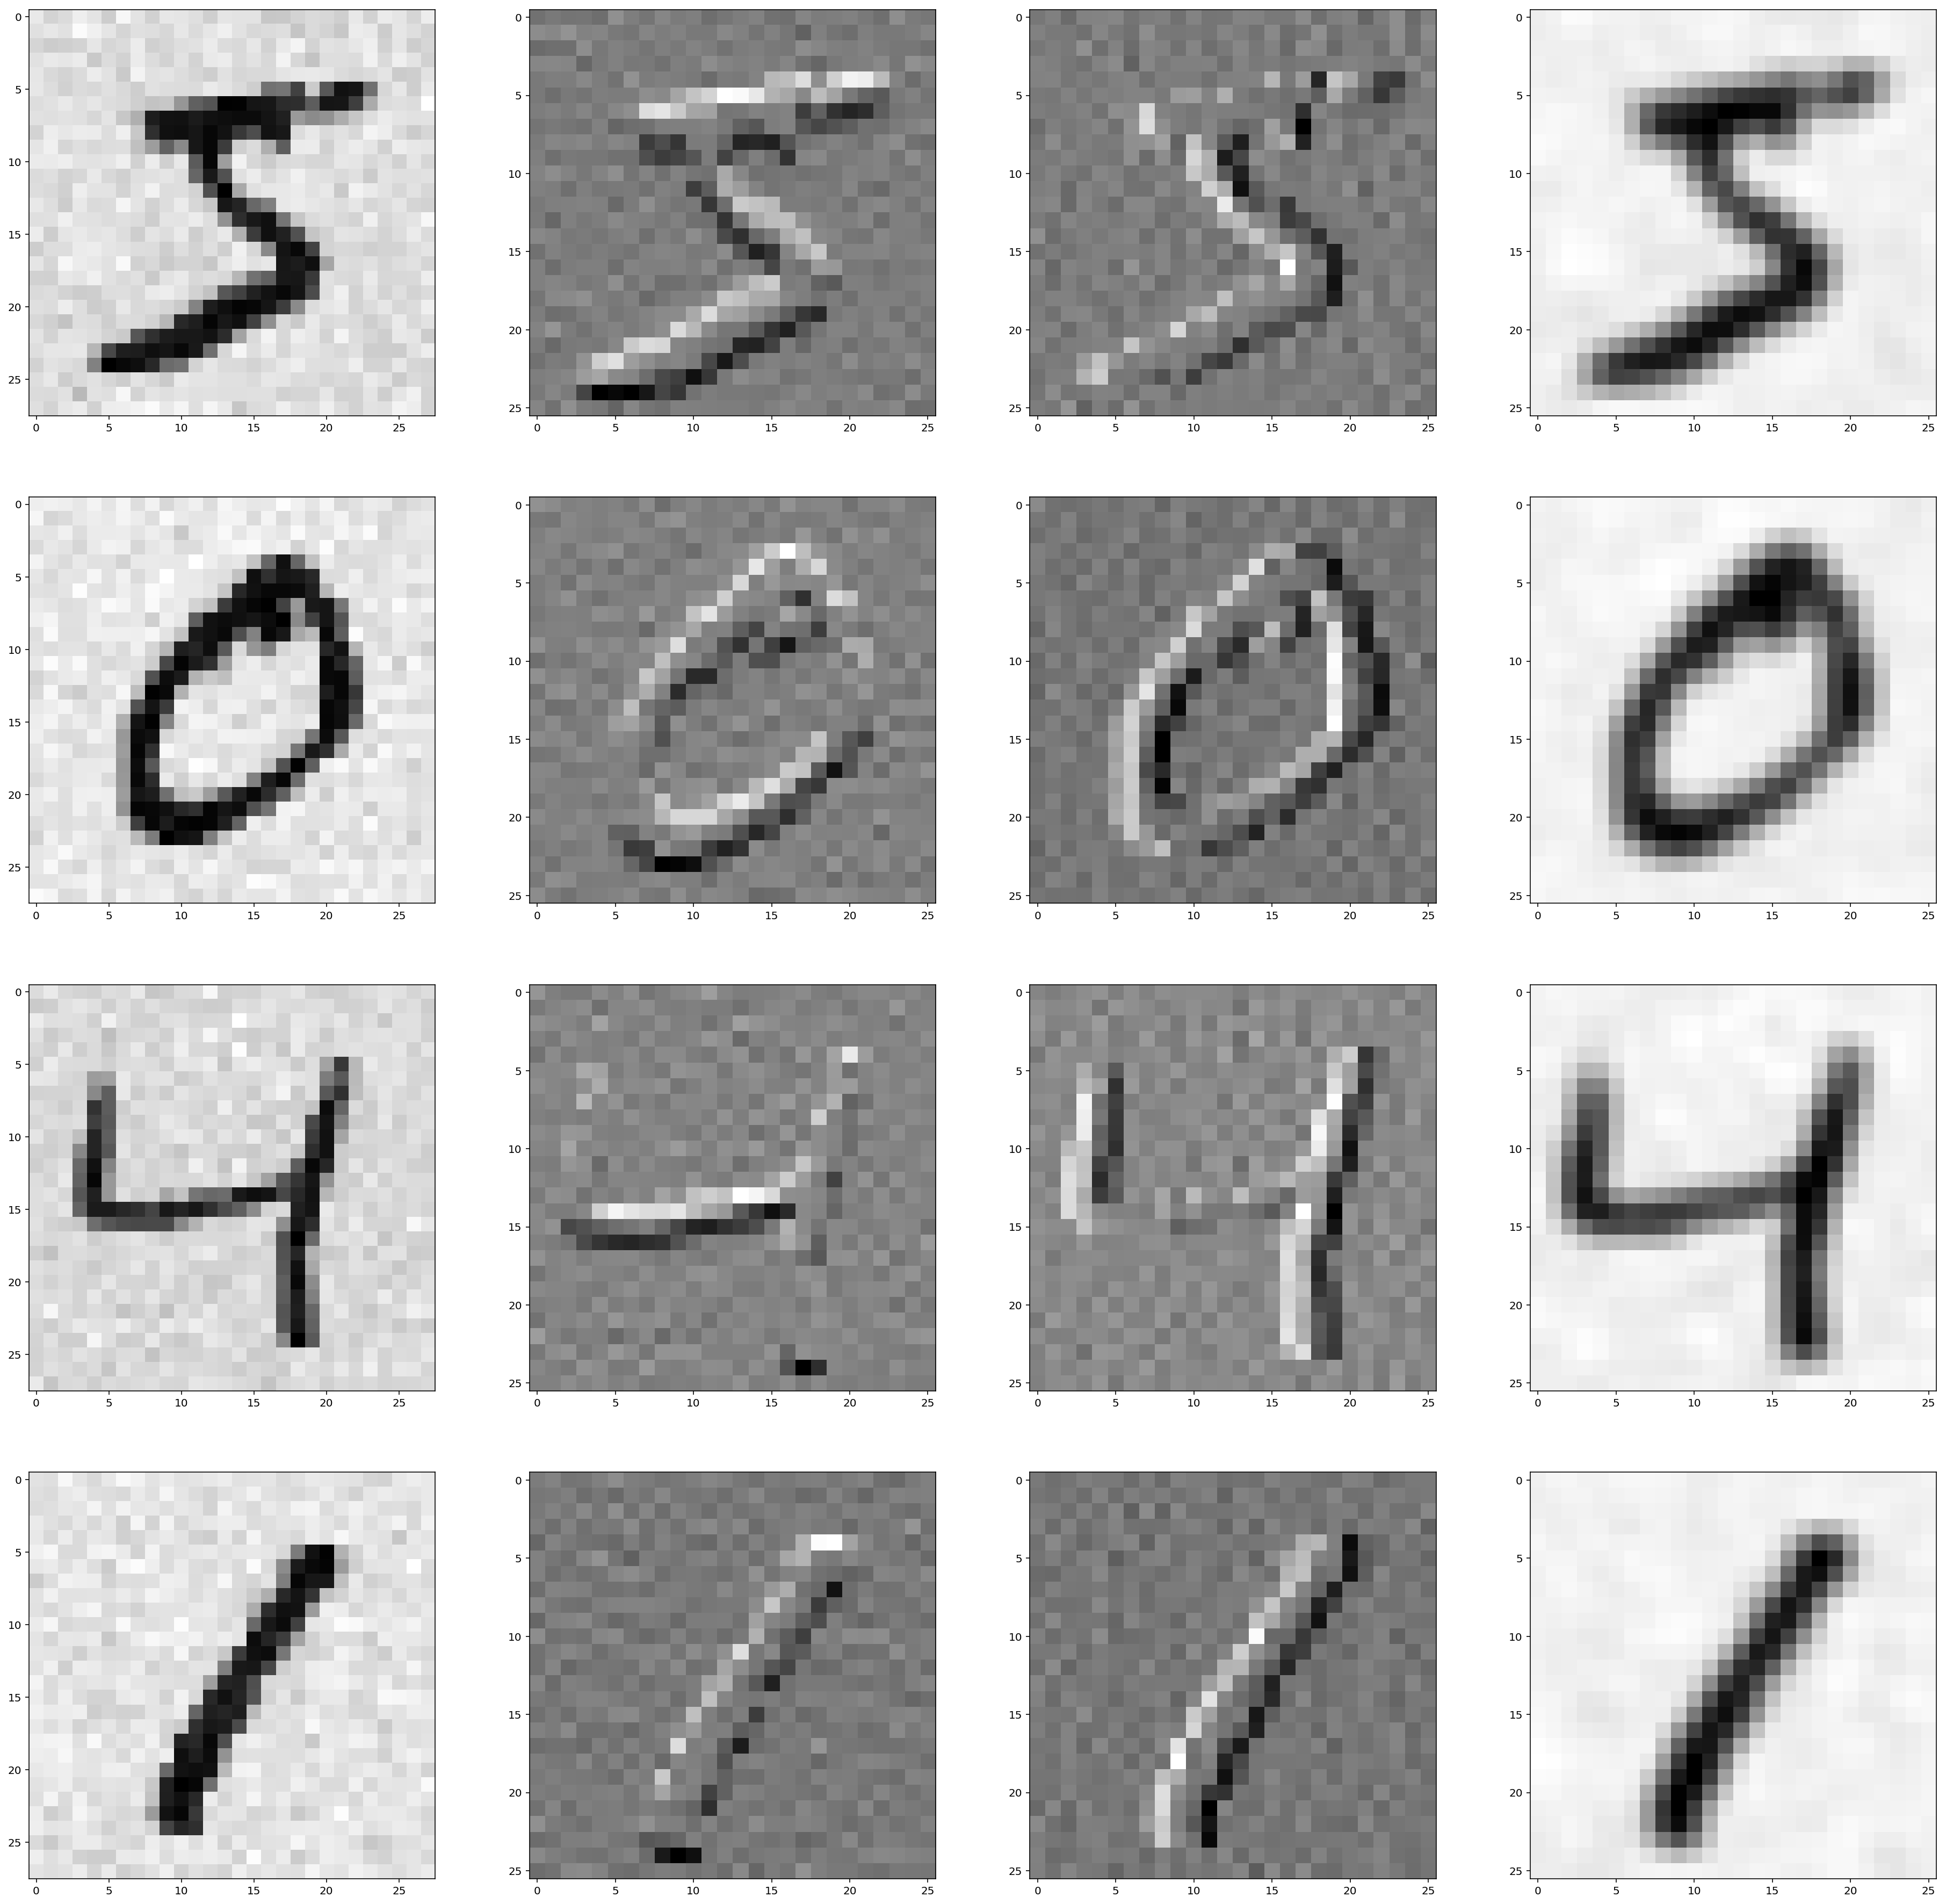

In [9]:
fig, axs = plt.subplots(n_examples, 4, figsize=(8*4, 8*n_examples))
for n, (ax1, ax2, ax3, ax4) in enumerate(axs):
    ax1.imshow(X_train_noisy[n,:,:,0], cmap=plt.cm.binary)
    ax2.imshow(X_conv[n,:,:,0], cmap=plt.cm.binary)
    ax3.imshow(X_conv[n,:,:,1], cmap=plt.cm.binary)
    ax4.imshow(X_conv[n,:,:,2], cmap=plt.cm.binary)

## Questions

Do you understand what you see?
* does the right kind of filter produce the right kind of behaviour?
* what are the different images shown per row?
* what if you put in more kernels?
* what if you change the size of the kernels?
* what is the size of the outputs?

Hint: google for some typical/well known image kernels and explore what they do.

## More convolutions

Let's apply some more convolutions to a more natural image.

In [10]:
# Use scikit-image to load images from disk
from skimage.io import imread
from skimage.transform import resize

sample image shape:  (3495, 5243, 3)


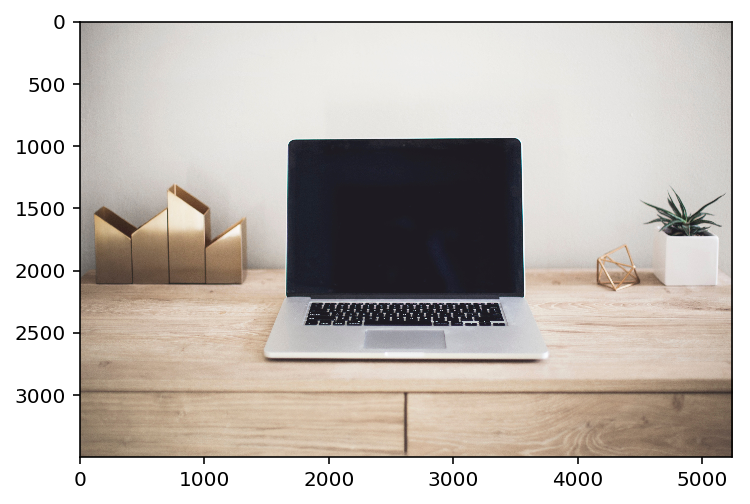

In [11]:
# Maybe grab an image of your own here
sample_image = imread("laptop2.jpg")
sample_image= sample_image.astype(float)

size = sample_image.shape
print("sample image shape: ", sample_image.shape)

plt.imshow(sample_image.astype('uint8'));

We will define a simple network that applies a convolutio to the image. Make sure it uses three kernels of size `5x5`. Investigate the `padding` argument. Set it so that the output image has the same size as the input (`padding='same'`).

How would you specify the input shape so that it works with images of any size? Hint: a size of `None` tells keras that the size will be defined at run time.

In [12]:
### BEGIN SOLUTION
import keras
from keras.models import Sequential
from keras.layers import Conv2D

conv = Sequential([
    Conv2D(filters=3, kernel_size=(5, 5), padding="same",
           input_shape=(None, None, 3))
])
conv.output_shape
### END SOLUTION

(None, None, None, 3)

Do you understand your model's `output_shape` property?

> If your image is large (like the example image) it is worth resizing it first to use less memory.

Keras expects you to pass in a batch of images. Even if this batch only contains one image:

In [13]:
small_sample_image = resize(sample_image, (800, 600))
img_in = np.expand_dims(small_sample_image, 0)
img_in.shape

(1, 800, 600, 3)

Apply this uninitialised/random filter to your image and plot it.

(1, 800, 600, 3) (1, 800, 600, 3)


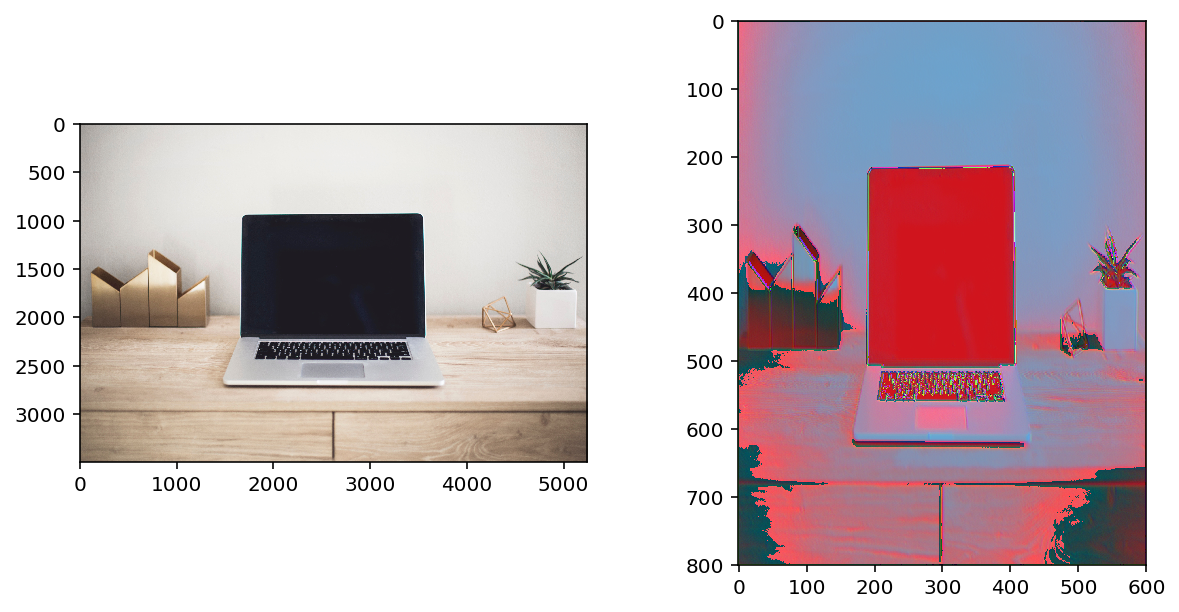

In [14]:
img_out = conv.predict(img_in)

print(img_in.shape, img_out.shape)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(sample_image.astype('uint8'))
ax1.imshow(img_out[0].astype('uint8'));

The output has 3 channels, hence can also be interpreted as an RGB image with matplotlib. However it is the result of a random convolutional filter applied to the original one.


Let's look at the parameters:

In [15]:
conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, None, None, 3)     228       
Total params: 228
Trainable params: 228
Non-trainable params: 0
_________________________________________________________________


The input image has 3 colors and a single convolution kernel mixes information from all the three input channels to compute its output.

A convolutional layer outputs many channels at once: each channel is the output of a distinct convolution operation (aka unit) of the layer.

So if you have three kernels (or filters) the output of your convolutional layer will be three feature maps. If there are three of them it feels natural to interpret them as the new "colours" and plot the resulting image.

Let's inspect the weights:

In [16]:
len(conv.get_weights())

2

In [17]:
weights = conv.get_weights()[0]
weights.shape

(5, 5, 3, 3)

Each of the 3 output channels is generated by a distinct convolution kernel.

Each convolution kernel has a spatial size of 5x5 and operates across 3 input channels.